### Начальные данные

In [137]:
import pandas as pd

data = pd.Series(data={
    'a':0.0,
    'b':2.0,
    'k':2.0,
    'T':0.1,
    'h':0.1
})

data

a    0.0
b    2.0
k    2.0
T    0.1
h    0.1
dtype: float64

In [138]:
def u0(x): return 0
def m1(t): return 0
def m2(t): return 2*t
def f(x, t): return 1
def tau(h) : return 0.45 * h ** 2 / data['k']

### Явная схема Лаосонена

In [139]:
import numpy as np


def _laosonen(y_current: list, tn_current: float, h: float) -> list:
    arr = [y_current[n] + tau(h) * (data['k'] *
                                    (y_current[n+1] - 2 *
                                     y_current[n] + y_current[n - 1])
                                    / h ** 2 + f(data['a'] + h * n, tn_current))
           for n in np.arange(1, len(y_current)-1)]
    arr = np.append(m1(tn_current + tau(h)), arr)
    return np.append(arr, m2(tn_current + tau(h)))


def laosen(h: float) -> pd.DataFrame:

    l1 = _laosonen([u0(i) for i in np.arange(data['a'] + h, data['b'],
                                             step=h)], 0, h)
    
    l1 = np.append(m1(0), l1)
    l1 = np.append(l1, m2(0))
    
    result = np.array(l1)

    tns = np.arange(tau(h), data['T'] + tau(h), tau(h))

    for tn in tns:
        l1 = _laosonen(l1, tn_current=tn, h=h)
        result = np.append(result, l1)

    result = pd.DataFrame(data=result.reshape(tns.shape[0]+1, -1), columns=np.arange(
        data['a'], data['b'] + h, h), index=np.append(0,tns))
    result.index.name = 't_n'
    result.columns.name = 'x_i'
    return result


res = laosen(data['h'])


### Отображение полученных слоев

In [140]:
import matplotlib.pyplot as plt

def print_contour(df: pd.DataFrame) -> None:
    plt.style.use('_mpl-gallery-nogrid')
    fig, ax = plt.subplots()
    X, Y = np.meshgrid(df.columns, df.index)
    Z = df.values

    contour = ax.contourf(X, Y, Z)
    cbar = fig.colorbar(contour)
    fig.set_figheight(4)
    fig.set_figwidth(6)
    ax.set_xlabel('x_i')
    ax.set_ylabel('t_n')
    fig.tight_layout()
    


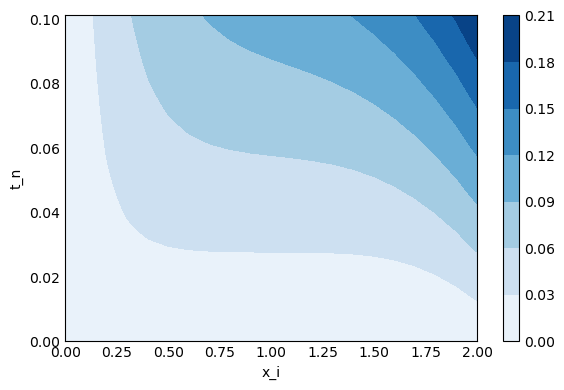

In [141]:
print_contour(res)

### Неявная схема "Зонтик"

In [142]:
def TDMA(a, b, c, d):

    nf = len(a)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    
    for it in range(1, nf):
        mc = ac[it]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1]
        dc[it] = dc[it] - mc*dc[it-1]

    xc = ac
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]
        
    return xc

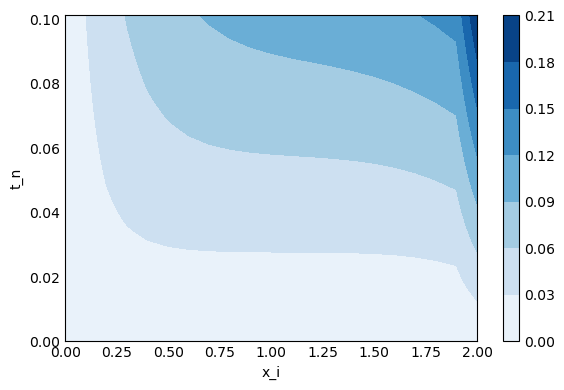

In [143]:
def _umbrella(y_current: list, tn_current: float, h: float) -> list:
    gamma = data['k'] * tau(h) / h ** 2
    d = -1 * np.array([y_current[i] + tau(h) * f(data['a'] + h * i, tn_current)
                       for i in np.arange(len(y_current))])

    a = np.repeat(gamma, len(y_current))
    b = np.repeat(-(1 + 2 * gamma), len(y_current))
    c = np.repeat(gamma, len(y_current))

    result = TDMA(a, b, c, d)
    result[0] = m1(tn_current+tau(h))
    result[-1] = m2(tn_current+tau(h))

    return result


def umbrella(h: float) -> pd.DataFrame:

    l1 = _umbrella([u0(i) for i in np.arange(data['a'] + h, data['b'],
                                             step=h)], 0, h)
    
    l1 = np.append(m1(0), l1)
    l1 = np.append(l1, m2(0))
    
    result = np.array(l1)

    tns = np.arange(tau(h), data['T'] + tau(h), tau(h))

    for tn in tns:
        l1 = _umbrella(l1, tn_current=tn, h=h)
        result = np.append(result, l1)

    result = pd.DataFrame(data=result.reshape(tns.shape[0]+1, -1), columns=np.arange(
        data['a'], data['b'] + h, h), index=np.append(0, tns))
    result.index.name = 't_n'
    result.columns.name = 'x_i'
    return result


res = umbrella(data['h'])
print_contour(res)